# Imports

In [2]:
from typing import Dict, Any
from pydantic import BaseModel, Field
from dataclasses import dataclass
from langgraph.graph import StateGraph, END

from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage
from langgraph.graph.message import add_messages
from typing import List, Annotated

# Step 1: Ingest Evidence into a Vector Database

In [45]:
# Set up ChromaDB and LLM (override if it already exists)
import os
import chromadb
from chromadb.config import Settings
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma

# Initialize embeddings (override if already exists)
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Initialize ChromaDB (override if already exists)
chroma_client = chromadb.PersistentClient(
    path="./chromadb",
    settings=Settings(anonymized_telemetry=False)
)

# # Initialize vector store (override if already exists)
# vector_store = Chroma(
#     client=chroma_client,
#     collection_name="documents",
#     embedding_function=embeddings,
#     collection_metadata={"hnsw:space": "cosine"},
# )
try:
    chroma_client.delete_collection("documents")
except Exception:
    pass  # Ignore if collection does not exist

vector_store = Chroma(
    client=chroma_client,
    collection_name="documents",
    embedding_function=embeddings,
    collection_metadata={"hnsw:space": "cosine"}
)

In [3]:
# Load text-to-SQL examples from dev.json
import json

# Load the dev.json file
with open('../../dev.json', 'r') as f:
    dev_data = json.load(f)

dev_data[0]


{'question_id': 0,
 'db_id': 'california_schools',
 'question': 'What is the highest eligible free rate for K-12 students in the schools in Alameda County?',
 'evidence': 'Eligible free rate for K-12 = `Free Meal Count (K-12)` / `Enrollment (K-12)`',
 'SQL': "SELECT `Free Meal Count (K-12)` / `Enrollment (K-12)` FROM frpm WHERE `County Name` = 'Alameda' ORDER BY (CAST(`Free Meal Count (K-12)` AS REAL) / `Enrollment (K-12)`) DESC LIMIT 1",
 'difficulty': 'simple'}

In [4]:
# Find and print the first toxicology question in dev_data
for item in dev_data:
    question = item.get("question", "")
    if "toxicology" in question.lower():
        print(item)
        break


{'question_id': 220, 'db_id': 'toxicology', 'question': 'Please list top three elements of the toxicology of the molecule TR000 in alphabetical order.', 'evidence': 'TR000 is the molecule id;', 'SQL': "SELECT DISTINCT T.element FROM atom AS T WHERE T.molecule_id = 'TR000' ORDER BY T.element LIMIT 3", 'difficulty': 'challenging'}


In [8]:
# Find and print the first formula_1 question in dev_data
for item in dev_data:
    question = item.get("question", "")
    if "formula_1" in question.lower() and item.get("evidence", ""):
        print(f'Question: {question}')
        print(f'Evidence: {item.get("evidence", "")}')


Question: Please give more information about the Formula_1 races that used the Silverstone Circuit.
Evidence: more information refers to url
Question: In which Formula_1 race did Lewis Hamilton rank the highest?
Evidence: rank the highest refers to min(rank); Lewis Hamilton refers to the full name of the driver; Full name of the driver refers to drivers.forename and drivers.surname;
Question: Among the drivers that finished the race in the 2008 Chinese Grand Prix, how many of them have participated in Formula_1 races?
Evidence: COUNT(raceID) > 0 reveals that this driver participated in races; drivers who finished the race refers to time has value.
Question: What is the average fastest lap time in seconds for Lewis Hamilton in all the Formula_1 races?
Evidence: average fastest lap time = avg(fastestLapTime); The time is recorded on 'MM:SS.mmm'
Question: What is the lap record set by Lewis Hamilton in a Formula_1 race?
Evidence: lap recod means the fastest time recorded which refers to t

In [47]:
# Create documents from the text-to-SQL examples
from langchain_core.documents import Document

documents = []
for item in dev_data:
    # Create a comprehensive document with question, evidence, and SQL
    evidences = [e.strip() for e in item['evidence'].split(';') if e.strip()]
    
    for evidence in evidences:
        doc = Document(
            page_content=evidence,
            metadata={
                "db_id": item["db_id"]
            }
        )
        documents.append(doc)

# Add documents to vector store
print(f"📚 Loading {len(documents)} text-to-SQL examples into vector store...")
vector_store.add_documents(documents)
print(f"✅ Added {len(documents)} text-to-SQL examples to the vector store")

# Show some statistics
db_counts = {}
for item in dev_data:
    db_id = item['db_id']
    db_counts[db_id] = db_counts.get(db_id, 0) + 1

print(f"\n📊 Database distribution:")
for db_id, count in sorted(db_counts.items()):
    print(f"  - {db_id}: {count} examples")


📚 Loading 2680 text-to-SQL examples into vector store...
✅ Added 2680 text-to-SQL examples to the vector store

📊 Database distribution:
  - california_schools: 89 examples
  - card_games: 191 examples
  - codebase_community: 186 examples
  - debit_card_specializing: 64 examples
  - european_football_2: 129 examples
  - financial: 106 examples
  - formula_1: 174 examples
  - student_club: 158 examples
  - superhero: 129 examples
  - thrombosis_prediction: 163 examples
  - toxicology: 145 examples


In [48]:
# Test a simple query against the ChromaDB vector store, only for db_id 'formula_1'

test_query = "Youngest driver in the 2024 season?"

print(f"\n🔎 Testing ChromaDB similarity search for query: '{test_query}' (db_id='formula_1')")
try:
    # Only search for documents with db_id 'formula_1'
    results = vector_store.similarity_search_with_score(
        test_query,
        k=3,
        filter={"db_id": "formula_1"}
    )
    for i, (doc, score) in enumerate(results, 1):
        print(f"{i}. Score: {1 - score:.4f} | Content: {doc.page_content[:100]}")
    if not results:
        print("No documents retrieved for db_id 'formula_1'.")
except Exception as e:
    print(f"❌ Error querying ChromaDB: {e}")




🔎 Testing ChromaDB similarity search for query: 'Youngest driver in the 2024 season?' (db_id='formula_1')
1. Score: 0.6419 | Content: youngest driver refers to Max (year(dob))
2. Score: 0.6105 | Content: Youngest racer = MAX(dob)
3. Score: 0.5844 | Content: the youngest is a driver where MAX(dob)


In [49]:
from utils import describe_database

# test with formula_1
db_path = "../../dbs/dev_databases/formula_1/formula_1.sqlite"
print(describe_database(db_path))


🧱 Table: circuits
   🔸 circuitId (INTEGER)
   🔸 circuitRef (TEXT)
   🔸 name (TEXT)
   🔸 location (TEXT)
   🔸 country (TEXT)
   🔸 lat (REAL)
   🔸 lng (REAL)
   🔸 alt (INTEGER)
   🔸 url (TEXT)

🧱 Table: constructors
   🔸 constructorId (INTEGER)
   🔸 constructorRef (TEXT)
   🔸 name (TEXT)
   🔸 nationality (TEXT)
   🔸 url (TEXT)

🧱 Table: drivers
   🔸 driverId (INTEGER)
   🔸 driverRef (TEXT)
   🔸 number (INTEGER)
   🔸 code (TEXT)
   🔸 forename (TEXT)
   🔸 surname (TEXT)
   🔸 dob (DATE)
   🔸 nationality (TEXT)
   🔸 url (TEXT)

🧱 Table: seasons
   🔸 year (INTEGER)
   🔸 url (TEXT)

🧱 Table: races
   🔸 raceId (INTEGER)
   🔸 year (INTEGER)
   🔸 round (INTEGER)
   🔸 circuitId (INTEGER)
   🔸 name (TEXT)
   🔸 date (DATE)
   🔸 time (TEXT)
   🔸 url (TEXT)
   🔗 Foreign Keys:
      circuitId → circuits.circuitId
      year → seasons.year

🧱 Table: constructorResults
   🔸 constructorResultsId (INTEGER)
   🔸 raceId (INTEGER)
   🔸 constructorId (INTEGER)
   🔸 points (REAL)
   🔸 status (TEXT)
   🔗 Foreig

# Build the RAG Workflow

In [50]:
@dataclass
class RetrievedDocument:
    """Represents a document retrieved from the vector store"""
    content: str  # The main content/text of the document
    metadata: Dict[str, Any]  # Metadata associated with the document (e.g., source, chunk id)
    score: float  # Similarity score for the retrieved document

class RAGState(BaseModel):
    """State for the RAG workflow"""
    db_path: str = ""  # The path to the database
    sql_result: Dict[str, Any] = Field(default_factory=dict)  # The result of the SQL query
    model_name: str = "gpt-4.1-mini"  # The model to use for the LLM
    messages: Annotated[List[BaseMessage], add_messages] = Field(default_factory=list)  # Conversation history/messages
    query: str = ""  # The user's query/question
    sql_query: str = ""  # The SQL query generated by the LLM
    reasoning: str = ""  # The reasoning for the SQL query
    retrieved_documents: List[RetrievedDocument] = Field(default_factory=list)  # List of retrieved documents
    context: str = ""  # Combined context from retrieved documents
    final_answer: str = ""  # The final answer generated by the system
    k: int = 5  # Number of documents to retrieve
    db_id: str = ""  # The database id (e.g., 'formula_1')


In [51]:
def begin_conversation(state: RAGState) -> Dict[str, Any]:
    # Create the prompt template
    system_prompt = """\
You are a helpful AI assistant that generates SQL queries to answer the user's question.\
"""

    return {
        "messages": [
            SystemMessage(content=system_prompt)
    ]
    }

In [52]:
def process_query(state: RAGState) -> Dict[str, Any]:
    """Process the incoming query and prepare for retrieval"""
    print(f"🔍 Processing query: {state.query}")
    
    # Add user message if not already present
    messages = state.messages.copy()
    if not any(isinstance(msg, HumanMessage) and msg.content == state.query for msg in messages):
        messages.append(HumanMessage(content=state.query))
    
    return {
        "messages": messages,
    }

In [ ]:
def retrieve_documents(state: RAGState) -> Dict[str, Any]:
    """Retrieve relevant documents from ChromaDB, matching the db_id in state."""
    print(f"📚 Retrieving top {state.k} documents for query: {state.query} (db_id: {state.db_id})")
    
    try:
        # Perform similarity search, filtering by db_id in metadata
        results = vector_store.similarity_search_with_score(
            query=state.query,
            k=state.k,
            filter={"db_id": state.db_id} if state.db_id else None
        )
        
        # Convert to RetrievedDocument objects
        retrieved_docs = []
        for doc, score in results:
            retrieved_docs.append(RetrievedDocument(
                content=doc.page_content,
                metadata=doc.metadata,
                score=1 - score  # Convert distance to similarity score
            ))
        
        print(f"✅ Retrieved {len(retrieved_docs)} documents")
        for i, doc in enumerate(retrieved_docs, 1):
            print(f"   {i}. Score: {doc.score:.4f} | Content: {doc.content[:100]}...")
        
        # Create context from retrieved documents
        context_parts = []
        for i, doc in enumerate(retrieved_docs, 1):
            context_parts.append(f"Document {i}:\n{doc.content}")
            if doc.metadata:
                context_parts.append(f"Metadata: {doc.metadata}")
            context_parts.append("")  # Empty line for separation
        
        context = "\n".join(context_parts)
        
        return {
            "retrieved_documents": retrieved_docs,
            "context": context,
        }de
        
    except Exception as e:
        print(f"❌ Error retrieving documents: {e}")
        return {
            "retrieved_documents": [],
            "context": "No documents could be retrieved due to an error.",
        }


In [54]:
class SQLOutput(BaseModel):
    reasoning: str = Field(description="think through step by step how to solve the problem.")
    sql_query: str = Field(description="The executable sql query")

    def dict(self):
        return {
            "reasoning": self.reasoning,
            "sql_query": self.sql_query
        }

def generate_sql_query(state: RAGState) -> Dict[str, Any]:
    """Generate sql query using retrieved documents"""
    print("🤖 Generating answer using retrieved context...")

    # Initialize LLM
    llm = ChatOpenAI(model=state.model_name, temperature=0).with_structured_output(SQLOutput)

    new_message = HumanMessage(content=f"Question: {state.query}\nContext: {state.context}\nDatabase Description: {describe_database(state.db_path)}")
    
    # Add new message to messages
    messages = [
        *state.messages,
        new_message
    ]
    
    try:
        # Generate response
        response = llm.invoke(messages)
        
        # Add AI response to messages
        
        return {
            "messages": [
                *messages,
                AIMessage(content=f'Reasoning: {response.reasoning}\nSQL Query: {response.sql_query}')
            ],
            "sql_query": response.sql_query,
            "reasoning": response.reasoning,
        }
        
    except Exception as e:
        error_msg = f"Error generating answer: {e}"
        print(f"❌ {error_msg}")
        
        updated_messages = state.messages.copy()
        updated_messages.append(AIMessage(content=error_msg))
        
        return {
            "messages": updated_messages,
            "final_answer": error_msg,
        }


In [55]:
def run_sql_query(state: RAGState) -> Dict[str, Any]:
    """Execute SQL query on the specified database"""
    import sqlite3
    import os
    
    print(f"🗃️ Executing SQL query on database '{state.db_id}': {state.sql_query}")
    
    try:
        
        if not os.path.exists(state.db_path):
            error_msg = f"Database {state.db_id} not found at {state.db_path}"
            print(f"❌ {error_msg}")
            return {
                "sql_result": {"error": error_msg},
                "final_answer": f"Error: {error_msg}"
            }
        
        # Connect to SQLite database
        conn = sqlite3.connect(state.db_path)
        cursor = conn.cursor()
        
        # Execute the query
        cursor.execute(state.sql_query)
        
        # Get column names
        columns = [description[0] for description in cursor.description] if cursor.description else []
        
        # Fetch results
        results = cursor.fetchall()
        
        conn.close()
        
        sql_result = {
            "success": True,
            "columns": columns,
            "data": results,
            "row_count": len(results),
            "sql_query": state.sql_query
        }
        
        print(f"✅ SQL query executed successfully! Found {len(results)} row(s)")
        
        # Format results for final answer
        if results:
            result_text = f"Query executed successfully! Found {len(results)} row(s):\\n\\n"
            
            # Add column headers
            if columns:
                result_text += " | ".join(columns) + "\\n"
                result_text += "-" * (len(" | ".join(columns))) + "\\n"
            
            # Add data rows (limit to first 10 for readability)
            for i, row in enumerate(results[:10]):
                result_text += " | ".join(str(cell) if cell is not None else "NULL" for cell in row) + "\\n"
            
            if len(results) > 10:
                result_text += f"\\n... and {len(results) - 10} more row(s)"
        else:
            result_text = "Query executed successfully but returned no results."
        
        return {
            "sql_result": sql_result,
            "final_answer": result_text
        }
        
    except Exception as e:
        error_msg = f"Error executing SQL query: {str(e)}"
        print(f"❌ {error_msg}")
        return {
            "sql_result": {"error": error_msg},
            "final_answer": error_msg
        }

In [56]:
# Create the workflow graph
workflow = StateGraph(RAGState)

# Add nodes
workflow.add_node("begin_conversation", begin_conversation)
workflow.add_node("process_query", process_query)
workflow.add_node("retrieve_documents", retrieve_documents)
workflow.add_node("generate_sql_query", generate_sql_query)
workflow.add_node("run_sql_query", run_sql_query)

# Add edges
workflow.add_edge("begin_conversation", "process_query")
workflow.add_edge("process_query", "retrieve_documents")
workflow.add_edge("retrieve_documents", "generate_sql_query")
workflow.add_edge("generate_sql_query", "run_sql_query")
workflow.add_edge("run_sql_query", END)

# Set entry point
workflow.set_entry_point("begin_conversation")

In [57]:
# Compile the workflow and suppress automatic rendering
compiled_workflow = workflow.compile()

# The compiled workflow is ready to use
print("✅ Workflow compiled successfully!")

✅ Workflow compiled successfully!


In [58]:
dev_data[0]

{'question_id': 0,
 'db_id': 'california_schools',
 'question': 'What is the highest eligible free rate for K-12 students in the schools in Alameda County?',
 'evidence': 'Eligible free rate for K-12 = `Free Meal Count (K-12)` / `Enrollment (K-12)`',
 'SQL': "SELECT `Free Meal Count (K-12)` / `Enrollment (K-12)` FROM frpm WHERE `County Name` = 'Alameda' ORDER BY (CAST(`Free Meal Count (K-12)` AS REAL) / `Enrollment (K-12)`) DESC LIMIT 1",
 'difficulty': 'simple'}

In [59]:
# run the graph
db_id = dev_data[0]["db_id"]
databases_dir = "../../dbs/dev_databases"
db_path = os.path.join(databases_dir, db_id, f"{db_id}.sqlite")
compiled_workflow.invoke(
    {
        "query": dev_data[0]["question"],
        "db_id": db_id,
        "db_path": db_path
        }
    )

🔍 Processing query: What is the highest eligible free rate for K-12 students in the schools in Alameda County?
📚 Retrieving top 5 documents for query: What is the highest eligible free rate for K-12 students in the schools in Alameda County? (db_id: california_schools)
✅ Retrieved 5 documents
   1. Score: 0.6392 | Content: Eligible free rate for K-12 = `Free Meal Count (K-12)` / `Enrollment (K-12)`...
   2. Score: 0.6392 | Content: Eligible free rate for K-12 = `Free Meal Count (K-12)` / `Enrollment (K-12)`...
   3. Score: 0.6031 | Content: percent of eligible free rate for K-12 = `Free Meal Count (K-12)` * 100 / `Enrollment (K-12)`...
   4. Score: 0.5666 | Content: Eligible free rates for students aged 5-17 = `Free Meal Count (Ages 5-17)` / `Enrollment (Ages 5-17)...
   5. Score: 0.5666 | Content: Eligible free rates for students aged 5-17 = `Free Meal Count (Ages 5-17)` / `Enrollment (Ages 5-17)...
🤖 Generating answer using retrieved context...
🗃️ Executing SQL query on database 'cal

{'db_path': '../../dbs/dev_databases/california_schools/california_schools.sqlite',
 'sql_result': {'success': True,
  'columns': ['Highest_Eligible_Free_Rate_K12'],
  'data': [(1.0,)],
  'row_count': 1,
  'sql_query': "SELECT MAX([Percent (%) Eligible Free (K-12)]) AS Highest_Eligible_Free_Rate_K12\nFROM frpm\nWHERE [County Name] = 'Alameda';"},
 'messages': [SystemMessage(content="You are a helpful AI assistant that generates SQL queries to answer the user's question.", additional_kwargs={}, response_metadata={}, id='1744b949-e4a0-48fc-a948-0657e614c72a'),
  HumanMessage(content='What is the highest eligible free rate for K-12 students in the schools in Alameda County?', additional_kwargs={}, response_metadata={}, id='71bb6df3-d1df-42ef-9fb4-1c7a52a93d55'),
  HumanMessage(content="Question: What is the highest eligible free rate for K-12 students in the schools in Alameda County?\nContext: Document 1:\nEligible free rate for K-12 = `Free Meal Count (K-12)` / `Enrollment (K-12)`\nMeta

In [60]:
# run sql query of dev_data[0]['SQL'] to check if they match
sql_query = dev_data[0]['SQL']
run_sql_query(RAGState(db_id=dev_data[0]["db_id"], sql_query=sql_query, db_path=db_path))

🗃️ Executing SQL query on database 'california_schools': SELECT `Free Meal Count (K-12)` / `Enrollment (K-12)` FROM frpm WHERE `County Name` = 'Alameda' ORDER BY (CAST(`Free Meal Count (K-12)` AS REAL) / `Enrollment (K-12)`) DESC LIMIT 1
✅ SQL query executed successfully! Found 1 row(s)


{'sql_result': {'success': True,
  'columns': ['`Free Meal Count (K-12)` / `Enrollment (K-12)`'],
  'data': [(1.0,)],
  'row_count': 1,
  'sql_query': "SELECT `Free Meal Count (K-12)` / `Enrollment (K-12)` FROM frpm WHERE `County Name` = 'Alameda' ORDER BY (CAST(`Free Meal Count (K-12)` AS REAL) / `Enrollment (K-12)`) DESC LIMIT 1"},
 'final_answer': 'Query executed successfully! Found 1 row(s):\\n\\n`Free Meal Count (K-12)` / `Enrollment (K-12)`\\n----------------------------------------------\\n1.0\\n'}

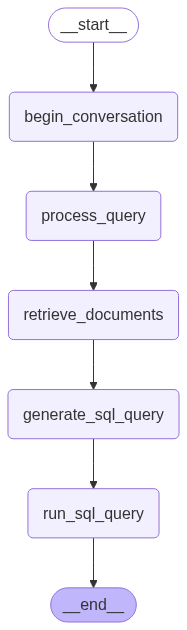

In [61]:
from IPython.display import Image, display

# Save the PNG to a file
png_bytes = compiled_workflow.get_graph().draw_mermaid_png()
with open("workflow_graph.png", "wb") as f:
    f.write(png_bytes)

# Display the image in the notebook
display(Image("workflow_graph.png"))

In [62]:
db_id = "california_schools"
databases_dir = "../../dbs/dev_databases"
db_path = os.path.join(databases_dir, db_id, f"{db_id}.sqlite")

compiled_workflow.invoke(
    {
        "query": "What is the highest eligible free rate for K-12 students in the schools in Alameda County?",
        "db_id": db_id,
        "db_path": db_path
        }
    )

🔍 Processing query: What is the highest eligible free rate for K-12 students in the schools in Alameda County?
📚 Retrieving top 5 documents for query: What is the highest eligible free rate for K-12 students in the schools in Alameda County? (db_id: california_schools)
✅ Retrieved 5 documents
   1. Score: 0.6390 | Content: Eligible free rate for K-12 = `Free Meal Count (K-12)` / `Enrollment (K-12)`...
   2. Score: 0.6390 | Content: Eligible free rate for K-12 = `Free Meal Count (K-12)` / `Enrollment (K-12)`...
   3. Score: 0.6030 | Content: percent of eligible free rate for K-12 = `Free Meal Count (K-12)` * 100 / `Enrollment (K-12)`...
   4. Score: 0.5665 | Content: Eligible free rates for students aged 5-17 = `Free Meal Count (Ages 5-17)` / `Enrollment (Ages 5-17)...
   5. Score: 0.5665 | Content: Eligible free rates for students aged 5-17 = `Free Meal Count (Ages 5-17)` / `Enrollment (Ages 5-17)...
🤖 Generating answer using retrieved context...
🗃️ Executing SQL query on database 'cal

{'db_path': '../../dbs/dev_databases/california_schools/california_schools.sqlite',
 'sql_result': {'success': True,
  'columns': ['Highest_Eligible_Free_Rate_K12'],
  'data': [(1.0,)],
  'row_count': 1,
  'sql_query': "SELECT MAX([Percent (%) Eligible Free (K-12)]) AS Highest_Eligible_Free_Rate_K12\nFROM frpm\nWHERE [County Name] = 'Alameda';"},
 'messages': [SystemMessage(content="You are a helpful AI assistant that generates SQL queries to answer the user's question.", additional_kwargs={}, response_metadata={}, id='281526f6-228b-43f9-bbd4-f9bce613b00e'),
  HumanMessage(content='What is the highest eligible free rate for K-12 students in the schools in Alameda County?', additional_kwargs={}, response_metadata={}, id='45cc0612-ccf6-41a3-aa13-d273312cf63b'),
  HumanMessage(content="Question: What is the highest eligible free rate for K-12 students in the schools in Alameda County?\nContext: Document 1:\nEligible free rate for K-12 = `Free Meal Count (K-12)` / `Enrollment (K-12)`\nMeta

In [63]:

compiled_workflow.invoke(
    {
        "query": "and the lowest?",
        "db_id": db_id,
        "db_path": db_path
        }
    )

🔍 Processing query: and the lowest?
📚 Retrieving top 5 documents for query: and the lowest? (db_id: california_schools)
✅ Retrieved 5 documents
   1. Score: 0.2737 | Content: the highest longitude refers to the school with the maximum absolute longitude value....
   2. Score: 0.2155 | Content: Eligible free rates for students aged 5-17 = `Free Meal Count (Ages 5-17)` / `Enrollment (Ages 5-17)...
   3. Score: 0.2155 | Content: Eligible free rates for students aged 5-17 = `Free Meal Count (Ages 5-17)` / `Enrollment (Ages 5-17)...
   4. Score: 0.2155 | Content: Eligible free rates for students aged 5-17 = `Free Meal Count (Ages 5-17)` / `Enrollment (Ages 5-17)...
   5. Score: 0.2117 | Content: Eligible free rate for K-12 = `Free Meal Count (K-12)` / `Enrollment (K-12)`...
🤖 Generating answer using retrieved context...
🗃️ Executing SQL query on database 'california_schools': SELECT School, Longitude FROM schools ORDER BY Longitude ASC LIMIT 1;
✅ SQL query executed successfully! Found 1 row

{'db_path': '../../dbs/dev_databases/california_schools/california_schools.sqlite',
 'sql_result': {'success': True,
  'columns': ['School', 'Longitude'],
  'data': [('Technical, Agricultural & Nat.', None)],
  'row_count': 1,
  'sql_query': 'SELECT School, Longitude FROM schools ORDER BY Longitude ASC LIMIT 1;'},
 'messages': [SystemMessage(content="You are a helpful AI assistant that generates SQL queries to answer the user's question.", additional_kwargs={}, response_metadata={}, id='9f78a8db-023a-4004-9f0b-da2784c20d75'),
  HumanMessage(content='and the lowest?', additional_kwargs={}, response_metadata={}, id='a9d2ac31-055f-45ff-a057-c57232a48919'),
  HumanMessage(content="Question: and the lowest?\nContext: Document 1:\nthe highest longitude refers to the school with the maximum absolute longitude value.\nMetadata: {'db_id': 'california_schools'}\n\nDocument 2:\nEligible free rates for students aged 5-17 = `Free Meal Count (Ages 5-17)` / `Enrollment (Ages 5-17)`\nMetadata: {'db_id

# Making a Stateful RAG

In [64]:
# Import the interrupt function for proper user input handling
from langgraph.types import interrupt

# Add a user input node for conversational flow using LangGraph interrupt
def ask_for_user_input(state: RAGState) -> Dict[str, Any]:
    """Ask user for the next question in the conversation using LangGraph interrupt"""
    print("\n" + "="*60)
    print("💬 SQL Query executed successfully!")
    print("="*60)
    
    # Show the result
    if state.final_answer:
        print("📊 RESULT:")
        print(state.final_answer.replace("\\\\n", "\n"))
    
    print("\n" + "-"*60)
    print("💭 What would you like to ask next?")
    print("   (Type 'exit' or 'quit' to end the conversation)")
    print("-"*60)
    
    # Use LangGraph interrupt instead of input() - this works properly in notebooks
    user_input = interrupt("Your question: ")
    
    if user_input and user_input.lower().strip() in ['exit', 'quit', 'bye', 'done']:
        return {
            "query": "",
            "final_answer": "👋 Goodbye! Thanks for using the SQL RAG system."
        }
    
    return {
        "query": user_input or "",
        "retrieved_documents": [],  # Reset for new query
        "context": "",
        "sql_query": "",
        "reasoning": "",
        "sql_result": {},
        "final_answer": ""
    }


In [65]:
# Conditional function to decide whether to continue or end
def should_continue(state: RAGState) -> str:
    """Decide whether to continue the conversation or end it"""
    if state.query == "" or state.query.lower() in ['exit', 'quit', 'bye', 'done']:
        return END
    else:
        return "process_query"


In [66]:
# Import MemorySaver for checkpointing (required for interrupt functionality)
from langgraph.checkpoint.memory import MemorySaver

# Create the conversational workflow graph with proper checkpointing
conversational_workflow = StateGraph(RAGState)

# Add nodes
conversational_workflow.add_node("begin_conversation", begin_conversation)
conversational_workflow.add_node("process_query", process_query)
conversational_workflow.add_node("retrieve_documents", retrieve_documents)
conversational_workflow.add_node("generate_sql_query", generate_sql_query)
conversational_workflow.add_node("run_sql_query", run_sql_query)
conversational_workflow.add_node("ask_for_user_input", ask_for_user_input)

# Add edges
conversational_workflow.add_edge("begin_conversation", "ask_for_user_input")
conversational_workflow.add_conditional_edges(
    "ask_for_user_input",
    should_continue,
    {
        "process_query": "process_query",
        END: END
    }
)
conversational_workflow.add_edge("process_query", "retrieve_documents")
conversational_workflow.add_edge("retrieve_documents", "generate_sql_query")
conversational_workflow.add_edge("generate_sql_query", "run_sql_query")
conversational_workflow.add_edge("run_sql_query", "ask_for_user_input")

# Set entry point
conversational_workflow.set_entry_point("begin_conversation")

# Set up memory for checkpointing (required for interrupt functionality)
memory = MemorySaver()

# Compile the conversational workflow with checkpointer
compiled_conversational_workflow = conversational_workflow.compile(checkpointer=memory)

print("✅ Conversational workflow compiled successfully with checkpointing!")


✅ Conversational workflow compiled successfully with checkpointing!


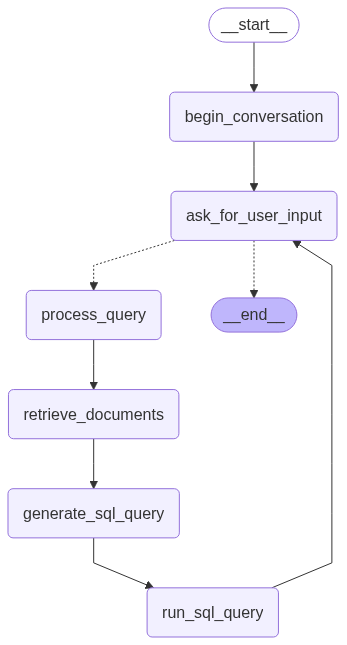

In [67]:
from IPython.display import Image, display

# Save the PNG to a file
png_bytes = compiled_conversational_workflow.get_graph().draw_mermaid_png()
with open("stateful_workflow_graph.png", "wb") as f:
    f.write(png_bytes)

# Display the image in the notebook
display(Image("stateful_workflow_graph.png"))

In [68]:
from langgraph.types import Command

def chat_with_sql_assistant(db_id: str = "formula_1"):
    """
    Start a continuous conversation with the SQL RAG assistant using a while loop.
    This works properly in notebooks using LangGraph's interrupt functionality.
    """
    print("🚀 Starting SQL RAG Chat Assistant!")
    print(f"📊 Database: {db_id}")
    print("💡 Type 'exit', 'quit', or 'bye' to end the conversation")
    print("=" * 60)
    
    # Set up database path
    db_path = f"../../dbs/dev_databases/{db_id}/{db_id}.sqlite"
    
    # Create initial state
    initial_state = {
        "db_id": db_id,
        "db_path": db_path,
        "query": "",
        "retrieved_documents": [],
        "context": "",
        "sql_query": "",
        "reasoning": "",
        "sql_result": {},
        "final_answer": ""
    }
    
    # Create a thread for this conversation
    thread = {"configurable": {"thread_id": f"chat_{db_id}"}}
    
    # Initialize the conversation
    conversation_started = False
    
    while True:
        try:
            if not conversation_started:
                # Start the conversation workflow
                print("\n🤖 Assistant: Hello! I'm ready to help you with SQL queries.")
                print("Ask me anything about the database, and I'll generate SQL to find the answer.")
                conversation_started = True
                
                # Start the workflow and wait for interrupt
                for event in compiled_conversational_workflow.stream(initial_state, thread, stream_mode="updates"):
                    if "__interrupt__" in event:
                        break
                    # Process other events silently for the first run
            
            # Get user input
            print("\n" + "-" * 40)
            user_input = input("👤 You: ").strip()
            
            # Check for exit conditions
            if user_input.lower() in ['exit', 'quit', 'bye', 'done', '']:
                print("\n👋 Assistant: Goodbye! Thanks for using the SQL RAG system.")
                break
            
            print(f"\n🔄 Processing: '{user_input}'")
            print("-" * 40)
            
            # Continue the conversation with user input
            for event in compiled_conversational_workflow.stream(
                Command(resume=user_input), 
                thread, 
                stream_mode="updates"
            ):
                if "__interrupt__" in event:
                    # Ready for next input
                    break
                else:
                    # Process events and show results
                    for node, data in event.items():
                        if node == "run_sql_query" and data and "final_answer" in data:
                            print("\n📊 Assistant: Here's what I found:")
                            print(data["final_answer"].replace("\\\\n", "\n"))
                        elif node in ["generate_sql_query"] and data and "sql_query" in data:
                            print(f"\n🔍 SQL Query: {data['sql_query']}")
                            
        except KeyboardInterrupt:
            print("\n\n⚠️ Conversation interrupted by user (Ctrl+C)")
            break
        except Exception as e:
            print(f"\n❌ Error: {e}")
            print("Let's try again...")
            continue

# Start the chat assistant
print("Ready to start chatting! Run the function below:")
print("chat_with_sql_assistant('formula_1')  # or any other database")


Ready to start chatting! Run the function below:
chat_with_sql_assistant('formula_1')  # or any other database


In [74]:
chat_with_sql_assistant("california_schools")

🚀 Starting SQL RAG Chat Assistant!
📊 Database: california_schools
💡 Type 'exit', 'quit', or 'bye' to end the conversation

🤖 Assistant: Hello! I'm ready to help you with SQL queries.
Ask me anything about the database, and I'll generate SQL to find the answer.

💬 SQL Query executed successfully!

------------------------------------------------------------
💭 What would you like to ask next?
   (Type 'exit' or 'quit' to end the conversation)
------------------------------------------------------------

----------------------------------------


👤 You:  What is the highest eligible free rate for K-12 students in the schools in Alameda County?



🔄 Processing: 'What is the highest eligible free rate for K-12 students in the schools in Alameda County?'
----------------------------------------

💬 SQL Query executed successfully!

------------------------------------------------------------
💭 What would you like to ask next?
   (Type 'exit' or 'quit' to end the conversation)
------------------------------------------------------------
🔍 Processing query: What is the highest eligible free rate for K-12 students in the schools in Alameda County?
📚 Retrieving top 5 documents for query: What is the highest eligible free rate for K-12 students in the schools in Alameda County? (db_id: california_schools)
✅ Retrieved 5 documents
   1. Score: 0.6392 | Content: Eligible free rate for K-12 = `Free Meal Count (K-12)` / `Enrollment (K-12)`...
   2. Score: 0.6392 | Content: Eligible free rate for K-12 = `Free Meal Count (K-12)` / `Enrollment (K-12)`...
   3. Score: 0.6031 | Content: percent of eligible free rate for K-12 = `Free Meal Count (

👤 You:  list all counties



🔄 Processing: 'list all counties'
----------------------------------------

💬 SQL Query executed successfully!
📊 RESULT:
Query executed successfully! Found 1 row(s):\n\nHighest_Eligible_Free_Rate\n--------------------------\n1.0\n

------------------------------------------------------------
💭 What would you like to ask next?
   (Type 'exit' or 'quit' to end the conversation)
------------------------------------------------------------
🔍 Processing query: list all counties
📚 Retrieving top 5 documents for query: list all counties (db_id: california_schools)
✅ Retrieved 5 documents
   1. Score: 0.5337 | Content: respective counties means PARTITION BY County...
   2. Score: 0.3217 | Content: complete address has Street, City, State, Zip code...
   3. Score: 0.2732 | Content: Ratio = count(schools in Colusa) / count(schools in Humboldt)...
   4. Score: 0.2676 | Content: Elementary School District refers to DOC = 52...
   5. Score: 0.2676 | Content: Elementary School District refers to DO

👤 You:  do it for alpine now



🔄 Processing: 'do it for alpine now'
----------------------------------------

💬 SQL Query executed successfully!
📊 RESULT:
Query executed successfully! Found 58 row(s):\n\nCounty\n------\nAlameda\nAlpine\nAmador\nButte\nCalaveras\nColusa\nContra Costa\nDel Norte\nEl Dorado\nFresno\n\n... and 48 more row(s)

------------------------------------------------------------
💭 What would you like to ask next?
   (Type 'exit' or 'quit' to end the conversation)
------------------------------------------------------------
🔍 Processing query: do it for alpine now
📚 Retrieving top 5 documents for query: do it for alpine now (db_id: california_schools)
✅ Retrieved 5 documents
   1. Score: 0.1753 | Content: Execellence Rate = NumGE1500 / NumTstTakr...
   2. Score: 0.1669 | Content: the highest longitude refers to the school with the maximum absolute longitude value....
   3. Score: 0.1625 | Content: complete address has Street, City, State, Zip code...
   4. Score: 0.1537 | Content: 'Offers a magne

👤 You:  exit



👋 Assistant: Goodbye! Thanks for using the SQL RAG system.


In [72]:
dev_data[0]

{'question_id': 0,
 'db_id': 'california_schools',
 'question': 'What is the highest eligible free rate for K-12 students in the schools in Alameda County?',
 'evidence': 'Eligible free rate for K-12 = `Free Meal Count (K-12)` / `Enrollment (K-12)`',
 'SQL': "SELECT `Free Meal Count (K-12)` / `Enrollment (K-12)` FROM frpm WHERE `County Name` = 'Alameda' ORDER BY (CAST(`Free Meal Count (K-12)` AS REAL) / `Enrollment (K-12)`) DESC LIMIT 1",
 'difficulty': 'simple'}

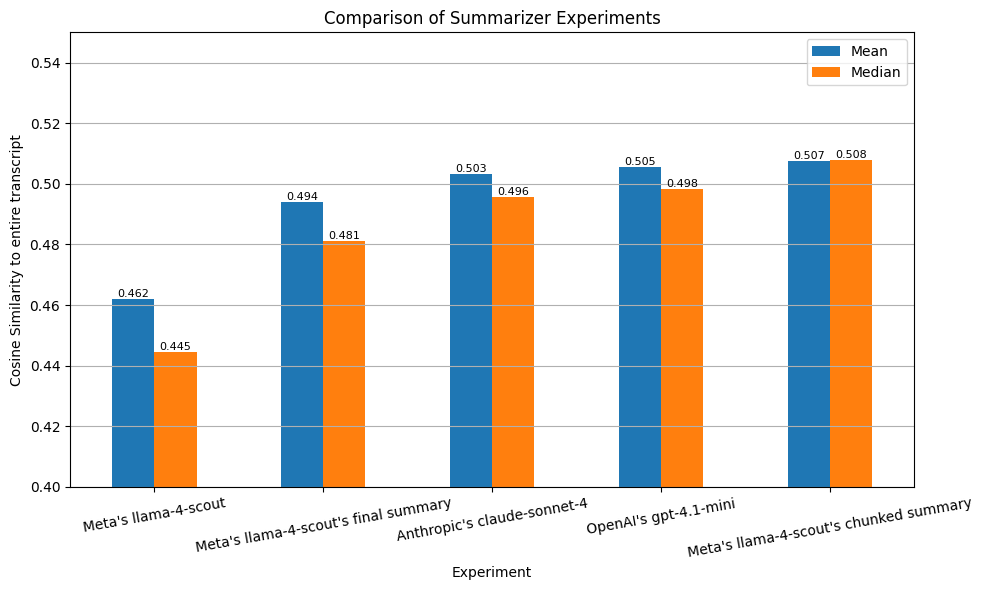

In [73]:
#rando, jsut for summarizer

import matplotlib.pyplot as plt
import pandas as pd

# Raw stats for each experiment
experiments_stats = {
    "Meta's llama-4-scout": {
        "Min": 0.3678571789392403,
        "Max": 0.6836765754435744,
        "Mean": 0.46183578170778994,
        "Median": 0.4445617459123098,
        "Std Dev": 0.07106599558449286
    },
    "Anthropic's claude-sonnet-4": {
        "Min": 0.35896196296172483,
        "Max": 0.6982867425041539,
        "Mean": 0.5030927317982371,
        "Median": 0.49581396432585395,
        "Std Dev": 0.07116457687719842
    },
    "OpenAI's gpt-4.1-mini": {
        "Min": 0.3684184556560857,
        "Max": 0.6892336894358907,
        "Mean": 0.5054158536689127,
        "Median": 0.49833240140267077,
        "Std Dev": 0.0653843868644675
    },
    "Meta's llama-4-scout's chunked summary": {
        "Min": 0.37662817378129276,
        "Max": 0.6869301348924637,
        "Mean": 0.5074499890537177,
        "Median": 0.5077038660215436,
        "Std Dev": 0.06659415576867475
    },
    "Meta's llama-4-scout's final summary": {
        "Min": 0.37285790166864557,
        "Max": 0.681617486689772,
        "Mean": 0.4938881698766774,
        "Median": 0.48126947546342846,
        "Std Dev": 0.0656388961983183
    }
}

# Convert to DataFrame and sort by Median
df = pd.DataFrame(experiments_stats).T
sorted_df = df.sort_values(by="Median", ascending=True)

# Filter to only Mean and Median
mean_median_df = sorted_df[["Mean", "Median"]]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = mean_median_df.plot(kind='bar', ax=ax)
plt.title("Comparison of Summarizer Experiments")
plt.ylabel("Cosine Similarity to entire transcript")
plt.xlabel("Experiment")
plt.xticks(rotation=10)
plt.ylim(0.4, 0.55)
plt.grid(True, axis='y')

# Add value labels
for container in bars.containers:
    bars.bar_label(container, fmt="%.3f", fontsize=8)

plt.tight_layout()
plt.savefig('summary_experiment.png', dpi=500)
plt.show()
